In [1]:
import numpy as np

class Vector:
    def __init__(self, x: float, y: float, z: float) -> None:
        """
        Initializes a Vector object with x, y, z coordinates.

        Parameters:
        x (float): X coordinate
        y (float): Y coordinate
        z (float): Z coordinate
        """
        self.coords = np.array([x, y, z], dtype=np.float32)

    def __str__(self) -> str:
        """
        String representation of the Vector.
        """
        return f"Vector({self.coords[0]:.2f}, {self.coords[1]:.2f}, {self.coords[2]:.2f})"

    def __add__(self, other: 'Vector') -> 'Vector':
        """
        Adds two Vector objects.

        Args:
        other (Vector): Another Vector.

        Returns:
        Vector: Sum of the two vectors.
        """
        result = self.coords + other.coords
        return Vector(result[0], result[1], result[2])

    def __sub__(self, other: 'Vector') -> 'Vector':
        """
        Subtracts two Vector objects.

        Args:
        other (Vector): Another Vector.

        Returns:
        Vector: Difference of the two vectors.
        """
        result = self.coords - other.coords
        return Vector(result[0], result[1], result[2])

    def dot(self, other: 'Vector') -> float:
        """
        Computes the dot product of two Vector objects.

        Args:
        other (Vector): Another Vector.

        Returns:
        float: Dot product of the two vectors.
        """
        return np.dot(self.coords, other.coords)

    def cross(self, other: 'Vector') -> 'Vector':
        """
        Computes the cross product of two Vector objects.

        Args:
        other (Vector): Another Vector.

        Returns:
        Vector: Cross product of the two vectors.
        """
        result = np.cross(self.coords, other.coords)
        return Vector(result[0], result[1], result[2])

    def magnitude(self) -> float:
        """
        Computes the magnitude of the Vector.

        Returns:
        float: Magnitude of the vector.
        """
        return np.linalg.norm(self.coords)
    
    def as_array(self):
        """
        Return the vector as a NumPy array.
        """
        return self.coords

# Example Usage
v1 = Vector(1, 2, 3)
v2 = Vector(4, 5, 6)

# Add vectors
v3 = v1 + v2
print(f"v1 + v2 = {v3}")

# Subtract vectors
v4 = v1 - v2
print(f"v1 - v2 = {v4}")

# Dot product
dot_product = v1.dot(v2)
print(f"v1 . v2 = {dot_product}")

# Cross product
v5 = v1.cross(v2)
print(f"v1 x v2 = {v5}")

# Magnitude
mag_v1 = v1.magnitude()
print(f"|v1| = {mag_v1}")


v1 + v2 = Vector(5.00, 7.00, 9.00)
v1 - v2 = Vector(-3.00, -3.00, -3.00)
v1 . v2 = 32.0
v1 x v2 = Vector(-3.00, 6.00, -3.00)
|v1| = 3.7416574954986572


In [2]:
import numpy as np
from typing import Union

class Frame:
    def __init__(self, r: np.ndarray, t: np.ndarray) -> None:
        """
        Initializes a Frame object with rotation and translation.

        Parameters:
        r (np.ndarray): Rotation matrix (3x3)
        t (np.ndarray): Translation vector (3,)
        """
        self.rotation = np.array(r)
        self.translation = np.array(t)

    def __array__(self):
        """
        Returns the Frame as a 4x4 homogeneous transformation matrix.
        """
        out = np.eye(4, dtype=np.float32)
        out[:3, :3] = self.rotation
        out[:3, 3] = self.translation
        return out

    def __str__(self) -> str:
        """
        String representation of the Frame as a numpy array.
        """
        return np.array_str(np.array(self), precision=4, suppress_small=True)

    def inv(self) -> 'Frame':
        """
        Returns the inverse of the Frame.

        Returns:
        Frame: The inverted Frame.
        """
        return Frame(self.rotation.T, -(self.rotation.T @ self.translation))

    def __matmul__(self, other):
        """
        Overloading the @ operator for Frame-to-Frame, Frame-to-Numpy array, or Frame-to-Vector multiplication.
        """
        if isinstance(other, Vector):
            # Apply rotation and translation to the vector
            transformed_coords = (self.rotation @ other.as_array().T).T + self.translation
            # Return a new Vector object with the transformed coordinates
            return Vector(transformed_coords[0], transformed_coords[1], transformed_coords[2])
        if isinstance(other, np.ndarray):
            # Apply rotation and then translation to a numpy array
            return (self.rotation @ other.T).T + self.translation
        elif isinstance(other, Frame):
            # Multiply rotation matrices and apply combined translation
            new_rotation = self.rotation @ other.rotation
            new_translation = self.rotation @ other.translation + self.translation
            return Frame(new_rotation, new_translation)
        elif isinstance(other, Vector):
            # Apply rotation and translation to a Vector object
            return (self.rotation @ other.as_array().T).T + self.translation
        else:
            raise TypeError(f"Unsupported operand type(s) for @: 'Frame' and '{type(other).__name__}'")



In [3]:
def read_calbody_file(file_path: str):
    """
    Reads a CALBODY.TXT file and extracts the d_i, a_i, and c_i vectors into separate lists.

    Args:
    file_path (str): Path to the CALBODY.TXT file.

    Returns:
    tuple: Three lists containing d_i, a_i, and c_i vectors respectively.
    """
    d_vectors = []  # List to store the d_i vectors
    a_vectors = []  # List to store the a_i vectors
    c_vectors = []  # List to store the c_i vectors

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # First line contains N_D, N_A, N_C, and filename
        header = lines[0].split(',')
        N_D = int(header[0].strip())  # Number of d_i markers (base)
        N_A = int(header[1].strip())  # Number of a_i markers (calibration object)
        N_C = int(header[2].strip())  # Number of c_i markers (EM markers)

        # Extract d_i vectors from lines 2 to N_D + 1
        for i in range(1, N_D + 1):
            d_coords = list(map(float, lines[i].split(',')))
            d_vectors.append(Vector(d_coords[0], d_coords[1], d_coords[2]))

        # Extract a_i vectors from lines N_D + 1 to N_D + N_A + 1
        for i in range(N_D + 1, N_D + N_A + 1):
            a_coords = list(map(float, lines[i].split(',')))
            a_vectors.append(Vector(a_coords[0], a_coords[1], a_coords[2]))

        # Extract c_i vectors from lines N_D + N_A + 1 to N_D + N_A + N_C + 1
        for i in range(N_D + N_A + 1, N_D + N_A + N_C + 1):
            c_coords = list(map(float, lines[i].split(',')))
            c_vectors.append(Vector(c_coords[0], c_coords[1], c_coords[2]))

    return d_vectors, a_vectors, c_vectors, N_D, N_A, N_C

# Example Usage
file_path = "./PA_1_Data/pa1-debug-a-calreadings.txt"
d_vectors, a_vectors, c_vectors, N_D, N_A, N_C = read_calbody_file(file_path)

# Output the vectors
print("d_i Vectors (Optical Markers on base of EM Tracker, wrt EM tracker):")
for vec in d_vectors:
    print(vec)
assert len(d_vectors) == N_D

print("\na_i Vectors (Optical Markers on Calibration Object, wrt Calibration Object):")
for vec in a_vectors:
    print(vec)
assert len(a_vectors) == N_A

print("\nc_i Vectors (EM Markers on Calibration Object, wrt Calibration Object):")
for vec in c_vectors:
    print(vec)
assert len(c_vectors) == N_C


d_i Vectors (Optical Markers on base of EM Tracker, wrt EM tracker):
Vector(0.00, 0.00, -1500.00)
Vector(0.00, 0.00, -1350.00)
Vector(0.00, 150.00, -1500.00)
Vector(0.00, 150.00, -1350.00)
Vector(150.00, 0.00, -1500.00)
Vector(150.00, 0.00, -1350.00)
Vector(150.00, 150.00, -1500.00)
Vector(150.00, 150.00, -1350.00)

a_i Vectors (Optical Markers on Calibration Object, wrt Calibration Object):
Vector(209.30, 208.87, -1288.97)
Vector(205.19, 207.84, -1039.00)
Vector(211.50, 458.85, -1287.91)
Vector(207.39, 457.83, -1037.95)
Vector(459.26, 206.65, -1284.87)
Vector(455.15, 205.63, -1034.91)
Vector(461.45, 456.64, -1283.81)
Vector(457.35, 455.62, -1033.85)

c_i Vectors (EM Markers on Calibration Object, wrt Calibration Object):
Vector(209.30, 208.87, 211.03)
Vector(207.25, 208.35, 336.01)
Vector(205.19, 207.84, 461.00)
Vector(210.40, 333.86, 211.56)
Vector(208.35, 333.35, 336.54)
Vector(206.29, 332.84, 461.53)
Vector(211.50, 458.85, 212.09)
Vector(209.44, 458.34, 337.07)
Vector(207.39, 457.8

In [4]:
def read_calreadings_file(file_path: str):
    """
    Reads a CALREADINGS.TXT file and organizes data by frame number. Each frame contains three lists of Vector objects
    for d_i, a_i, and c_i vectors.

    Args:
    file_path (str): Path to the CALREADINGS.TXT file.

    Returns:
    dict: A dictionary where the key is the frame number, and the value is a dictionary containing:
        - d_vectors: List of Vector objects for d_i coordinates
        - a_vectors: List of Vector objects for a_i coordinates
        - c_vectors: List of Vector objects for c_i coordinates
    """
    frames_data = {}  # Dictionary to store data for each frame

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # First line contains N_D, N_A, N_C, N_frames, and filename
        header = lines[0].split(',')
        N_D = int(header[0].strip())  # Number of d_i markers
        N_A = int(header[1].strip())  # Number of a_i markers
        N_C = int(header[2].strip())  # Number of c_i markers
        N_frames = int(header[3].strip())  # Number of data frames
        filename = header[4].strip()  # The filename is stored here as a string

        # Initialize the reading process
        line_index = 1  # Start reading after the header

        for frame_num in range(1, N_frames + 1):
            frame_dict = {
                'd_vectors': [],
                'a_vectors': [],
                'c_vectors': []
            }


            # Extract d_i vectors (N_D lines)
            for _ in range(N_D):
                d_coords = list(map(float, lines[line_index].split(',')))
                frame_dict['d_vectors'].append(Vector(d_coords[0], d_coords[1], d_coords[2]))
                line_index += 1

            # Extract a_i vectors (N_A lines)
            for _ in range(N_A):
                a_coords = list(map(float, lines[line_index].split(',')))
                frame_dict['a_vectors'].append(Vector(a_coords[0], a_coords[1], a_coords[2]))
                line_index += 1

            # Extract c_i vectors (N_C lines)
            for _ in range(N_C):
                c_coords = list(map(float, lines[line_index].split(',')))
                frame_dict['c_vectors'].append(Vector(c_coords[0], c_coords[1], c_coords[2]))
                line_index += 1

            # Store the frame data in the dictionary
            frames_data[frame_num] = frame_dict

    return frames_data

# Example Usage
file_path = "./PA_1_Data/pa1-debug-a-calreadings.txt"
frames_data = read_calreadings_file(file_path)

# Output the vectors for each frame
for frame_num, frame_data in frames_data.items():
    print(f"Frame {frame_num}:")

    print("  D_i Vectors (Optical Markers on EM tracker, wrt Optical Tracker):")
    for vec in frame_data['d_vectors']:
        print(f"    {vec}")

    print("  A_i Vectors (Optical Markers on Calibration Object, wrt Optical Tracker ):")
    for vec in frame_data['a_vectors']:
        print(f"    {vec}")

    print("  C_i Vectors (EM Markers on Calibration Object, wrt EM tracker):")
    for vec in frame_data['c_vectors']:
        print(f"    {vec}")

    print()


Frame 1:
  D_i Vectors (Optical Markers on EM tracker, wrt Optical Tracker):
    Vector(0.00, 0.00, -1500.00)
    Vector(0.00, 0.00, -1350.00)
    Vector(0.00, 150.00, -1500.00)
    Vector(0.00, 150.00, -1350.00)
    Vector(150.00, 0.00, -1500.00)
    Vector(150.00, 0.00, -1350.00)
    Vector(150.00, 150.00, -1500.00)
    Vector(150.00, 150.00, -1350.00)
  A_i Vectors (Optical Markers on Calibration Object, wrt Optical Tracker ):
    Vector(209.30, 208.87, -1288.97)
    Vector(205.19, 207.84, -1039.00)
    Vector(211.50, 458.85, -1287.91)
    Vector(207.39, 457.83, -1037.95)
    Vector(459.26, 206.65, -1284.87)
    Vector(455.15, 205.63, -1034.91)
    Vector(461.45, 456.64, -1283.81)
    Vector(457.35, 455.62, -1033.85)
  C_i Vectors (EM Markers on Calibration Object, wrt EM tracker):
    Vector(209.30, 208.87, 211.03)
    Vector(207.25, 208.35, 336.01)
    Vector(205.19, 207.84, 461.00)
    Vector(210.40, 333.86, 211.56)
    Vector(208.35, 333.35, 336.54)
    Vector(206.29, 332.84, 46

In [5]:
import numpy as np
from scipy.optimize import least_squares
from scipy.spatial.transform import Rotation as R

def rodrigues_to_rotation_matrix(rvec):
    """Convert a Rodrigues vector to a 3x3 rotation matrix."""
    return R.from_rotvec(rvec).as_matrix()

def residuals(params, source_points, target_points):
    """Compute the residuals (differences) between transformed source_points and target_points."""
    rvec = params[:3]  # First three parameters are the axis-angle representation of rotation
    t = params[3:]  # Last three parameters are the translation vector

    # Compute rotation matrix from the axis-angle representation
    R_matrix = rodrigues_to_rotation_matrix(rvec)

    # Transform source_points using the current R and t
    transformed_source = np.dot(source_points, R_matrix.T) + t

    # Compute residuals (difference between transformed source_points and target_points)
    return (transformed_source - target_points).ravel()  # Flatten to a 1D array for least_squares

def point_cloud_registration_least_squares(target_points, source_points):
    """
    Perform point cloud registration between target_points and source_points using least squares.
    
    Args:
    target_points (np.ndarray): Nx3 array of points from calreadings (e.g., A_vectors, D_vectors, C_vectors).
    source_points (np.ndarray): Nx3 array of points from calbody.
    
    Returns:
    R (np.ndarray): 3x3 optimal rotation matrix.
    t (np.ndarray): 3x1 translation vector.
    """
    # Initial guess for parameters: rotation as [0, 0, 0] (no rotation), translation as [0, 0, 0]
    initial_params = np.zeros(6)

    # Use least squares to minimize the residuals
    result = least_squares(residuals, initial_params, args=(source_points, target_points))

    # Extract the optimal parameters from the result
    rvec_optimal = result.x[:3]
    t_optimal = result.x[3:]

    # Convert the optimal Rodrigues vector to a rotation matrix
    R_optimal = rodrigues_to_rotation_matrix(rvec_optimal)

    return R_optimal, t_optimal

def perform_registration_for_frames(calreadings_frames, calbody_vectors, vector_type):
    """
    Perform point cloud registration for each frame in calreadings, selecting the type of vectors (A, D, or C).
    
    Args:
    calreadings_frames (dict): Dictionary where each key is a frame number and value is a dict of A_vectors, D_vectors, or C_vectors.
    calbody_vectors (list): List of vectors from calbody (corresponding to the selected vector type).
    vector_type (str): The type of vector to use ('A', 'D', or 'C').
    
    Returns:
    dict: Dictionary with frame numbers as keys and (R, t) as values where R is the rotation matrix and t is the translation vector.
    """
    registration_results = {}

    # Convert calbody vectors (for the selected type) to a numpy array
    source_points = np.array([vec.coords for vec in calbody_vectors])

    # Select the appropriate vectors from calreadings_frames based on vector_type
    vector_key = f'{vector_type.lower()}_vectors'  # e.g., 'a_vectors', 'd_vectors', 'c_vectors'

    # Perform registration for each frame
    for frame_num, frame_data in calreadings_frames.items():
        # Check if the vector type exists in the frame data
        if vector_key not in frame_data:
            raise KeyError(f"Vector type '{vector_type}' not found in frame {frame_num}. Available keys: {list(frame_data.keys())}")

        # Extract the target points (e.g., A_vectors, D_vectors, C_vectors) for the current frame
        target_points = np.array([vec.coords for vec in frame_data[vector_key]])

        # Perform point cloud registration using least squares to find R and t
        R_optimal, t_optimal = point_cloud_registration_least_squares(target_points, source_points)

        # Store the result for this frame
        registration_results[frame_num] = Frame(R_optimal, t_optimal)

    return registration_results

frames_data = read_calreadings_file(file_path)
# Example Usage:
calreadings_frames = frames_data
calbody_vectors = a_vectors
# Perform registration for each frame
F_A_point_cloud = perform_registration_for_frames(calreadings_frames, calbody_vectors, vector_type='A')

# Output the registration results
for frame_num, result in F_A_point_cloud.items():
    print(f"Frame {frame_num}:")
    print(f"  Rotation matrix (R):\n{result.rotation}")
    print(f"  Translation vector (t): {result.translation}")


Frame 1:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]
Frame 2:
  Rotation matrix (R):
[[ 9.99316743e-01 -2.82571604e-02  2.38239439e-02]
 [ 2.82503422e-02  9.99600685e-01  6.22772499e-04]
 [-2.38320284e-02  5.06875820e-05  9.99715976e-01]]
  Translation vector (t): [ 36.1040255   -3.26179798 242.2408329 ]
Frame 3:
  Rotation matrix (R):
[[ 0.99939304 -0.03193952  0.01390744]
 [ 0.03173441  0.99938783  0.01472743]
 [-0.01436932 -0.01427715  0.99979482]]
  Translation vector (t): [ 26.65991937 255.36388633   5.18728448]
Frame 4:
  Rotation matrix (R):
[[ 9.99955839e-01  9.39736326e-03 -9.59956480e-05]
 [-9.38914352e-03  9.99416625e-01  3.28367790e-02]
 [ 4.04518787e-04 -3.28344276e-02  9.99460723e-01]]
  Translation vector (t): [ -2.00021586 286.08411721 245.24653407]
Frame 5:
  Rotation matrix (R):
[[ 0.99963609 -0.02534023  0.0092501 ]
 [ 0.02526592  0.99964824  0.00806414]
 [-0.00945119 -0.00782749  0.9999247 ]]
  Translation vector 

Frame 1 RMSE: 0.0


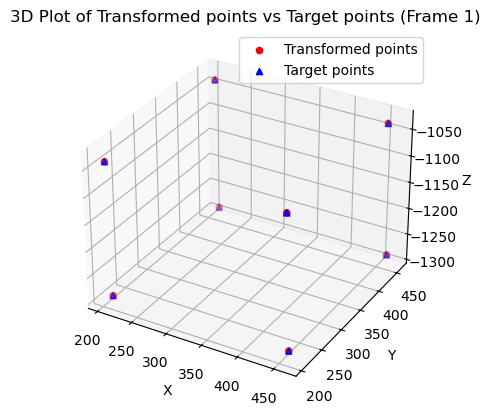

Frame 2 RMSE: 0.002920676488429308


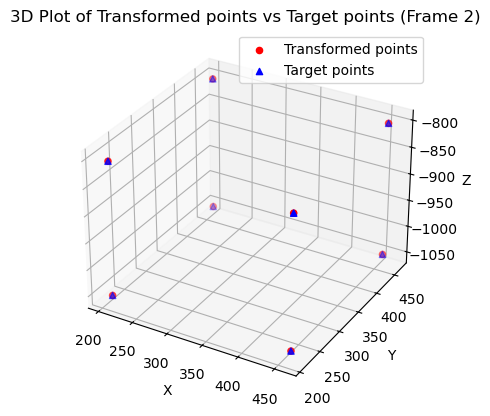

Frame 3 RMSE: 0.0032528387382626534


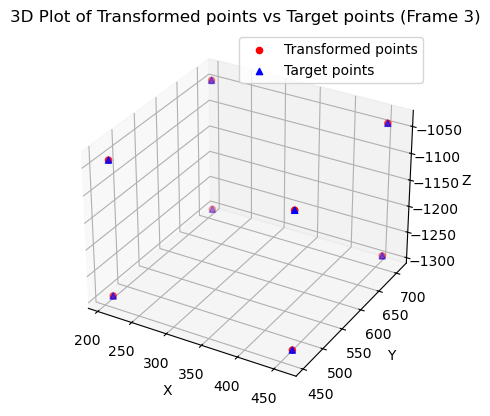

Frame 4 RMSE: 0.003317815950140357


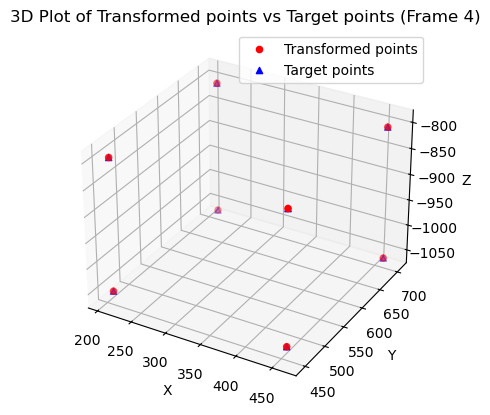

Frame 5 RMSE: 0.003431128803640604


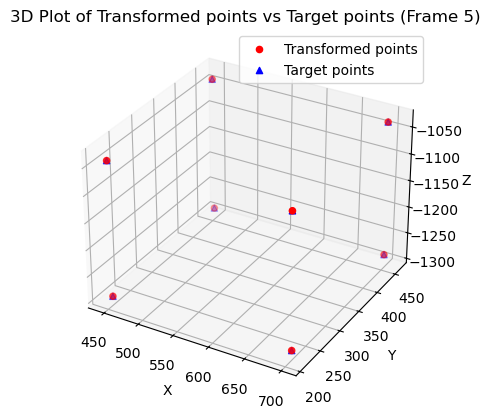

Frame 6 RMSE: 0.0035790237598121166


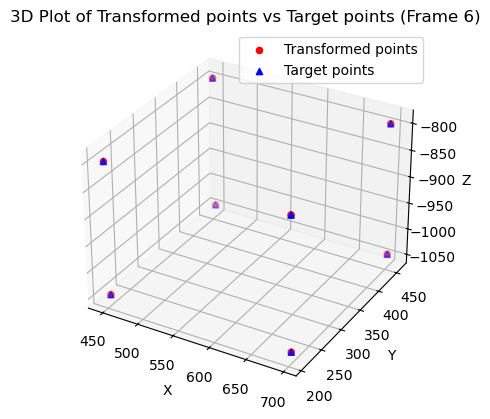

Frame 7 RMSE: 0.0031415200792253017


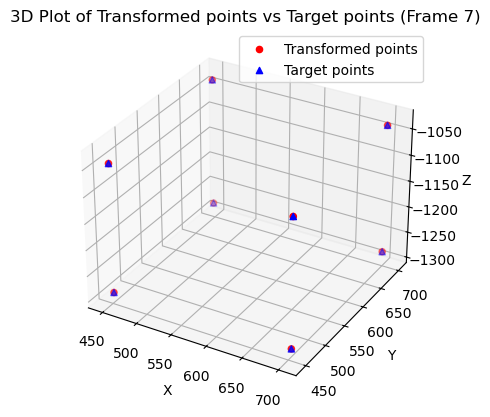

Frame 8 RMSE: 0.0030557289719581604


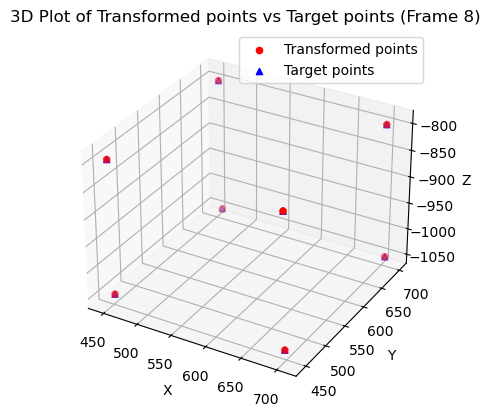

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def transform_points(frame, source_vectors):
    """
    Apply the transformation (rotation + translation) to a list of source Vector objects.
    
    Args:
    frame (Frame): Frame object containing rotation matrix and translation vector.
    source_vectors (list of Vector): List of Vector objects to be transformed.
    
    Returns:
    list of Vector: List of transformed Vector objects.
    """
    transformed_vectors = []

    # Loop through each Vector in source_vectors and transform using the Frame
    for vector in source_vectors:
        # Apply the Frame transformation to the Vector
        transformed_vector = frame @ vector
        transformed_vectors.append(transformed_vector)

    return transformed_vectors

def compute_rmse(transformed_points, target_points):
    """
    Compute the Root Mean Squared Error (RMSE) between transformed points and target points.
    
    Args:
    transformed_points (np.ndarray): Nx3 array of transformed points.
    target_points (np.ndarray): Nx3 array of target points.
    
    Returns:
    float: The RMSE value.
    """
    return np.sqrt(np.mean((transformed_points - target_points) ** 2))

def plot_3d_transformed_vs_target(frame_num, transformed_vectors, target_vectors):
    """
    Plot the transformed source vectors and the target vectors in 3D space.
    
    Args:
    frame_num (int): Frame number to display in the title.
    transformed_vectors (list of Vector): List of transformed Vector objects.
    target_vectors (list of Vector): List of target Vector objects.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Convert transformed_vectors and target_vectors from lists of Vector objects to NumPy arrays
    transformed_points = np.array([vector.as_array() for vector in transformed_vectors])
    target_points = np.array([vector.as_array() for vector in target_vectors])

    # Plot transformed points in red
    ax.scatter(transformed_points[:, 0], transformed_points[:, 1], transformed_points[:, 2], c='r', marker='o', label='Transformed points')

    # Plot target points in blue
    ax.scatter(target_points[:, 0], target_points[:, 1], target_points[:, 2], c='b', marker='^', label='Target points')

    # Set labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Add legend and title
    plt.legend()
    plt.title(f'3D Plot of Transformed points vs Target points (Frame {frame_num})')
    plt.show()


F_A_point_cloud = perform_registration_for_frames(calreadings_frames, calbody_vectors, vector_type='A')

rmse_results = {}

# Loop through each frame in the point cloud registration results
for frame_num, frame in F_A_point_cloud.items():
    # Extract the source points (calbody a_vectors) for transformation
    a_points = [Vector(vec.coords[0], vec.coords[1], vec.coords[2]) for vec in calbody_vectors]  # Source points (a_vectors)
    
    # Extract the target points (A_points) from calreadings_frames
    A_points = [Vector(vec.coords[0], vec.coords[1], vec.coords[2]) for vec in calreadings_frames[frame_num]['a_vectors']]  # Target points

    # Apply the transformation to a_points
    transformed_a_points = transform_points(frame, a_points)

    # Compute the RMSE between the transformed a_points and A_points
    transformed_array = np.array([v.as_array() for v in transformed_a_points])
    target_array = np.array([v.as_array() for v in A_points])
    rmse = compute_rmse(transformed_array, target_array)
    rmse_results[frame_num] = rmse

    # Output the RMSE result
    print(f"Frame {frame_num} RMSE: {rmse}")

    # Plot the transformed a_points vs target A_points
    plot_3d_transformed_vs_target(frame_num, transformed_a_points, A_points)


In [7]:
calreadings_frames = frames_data
calbody_vectors = d_vectors
# Perform registration for each frame
F_D_point_cloud = perform_registration_for_frames(calreadings_frames, calbody_vectors, vector_type='D')

# Output the registration results
for frame_num, result in F_D_point_cloud.items():
    print(f"Frame {frame_num}:")
    print(f"  Rotation matrix (R):\n{result.rotation}")
    print(f"  Translation vector (t): {result.translation}")


Frame 1:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]
Frame 2:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]
Frame 3:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]
Frame 4:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]
Frame 5:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]
Frame 6:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]
Frame 7:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]
Frame 8:
  Rotation matrix (R):
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
  Translation vector (t): [0. 0. 0.]


In [8]:
for i in range(1, 8):
    print(d_vectors[i].as_array(), frame_data["d_vectors"][i].as_array()) #HUH!

[    0.     0. -1350.] [    0.     0. -1350.]
[    0.   150. -1500.] [    0.   150. -1500.]
[    0.   150. -1350.] [    0.   150. -1350.]
[  150.     0. -1500.] [  150.     0. -1500.]
[  150.     0. -1350.] [  150.     0. -1350.]
[  150.   150. -1500.] [  150.   150. -1500.]
[  150.   150. -1350.] [  150.   150. -1350.]


In [9]:
F_D_frames = F_D_point_cloud

Frame 1 RMSE: 0.0


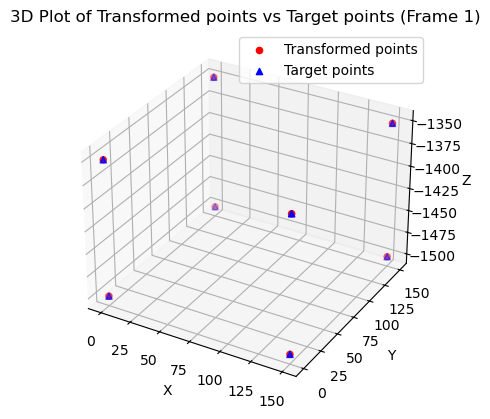

Frame 2 RMSE: 0.0


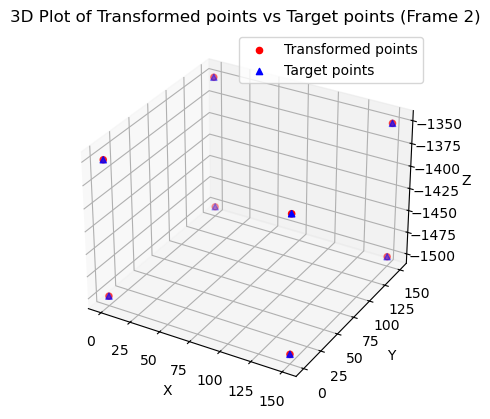

Frame 3 RMSE: 0.0


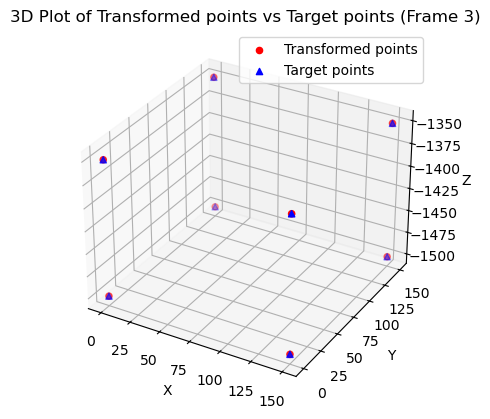

Frame 4 RMSE: 0.0


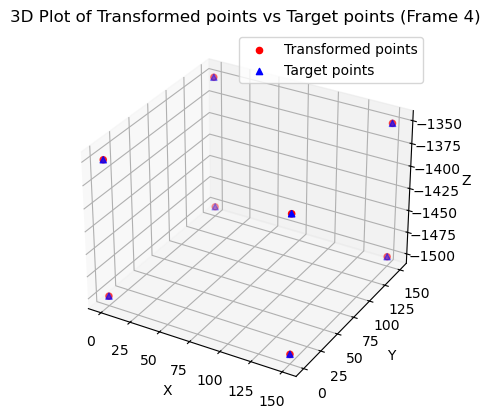

Frame 5 RMSE: 0.0


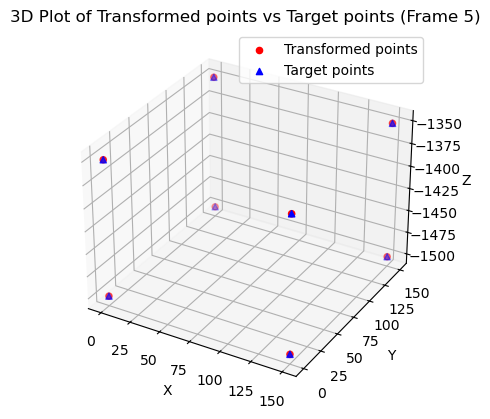

Frame 6 RMSE: 0.0


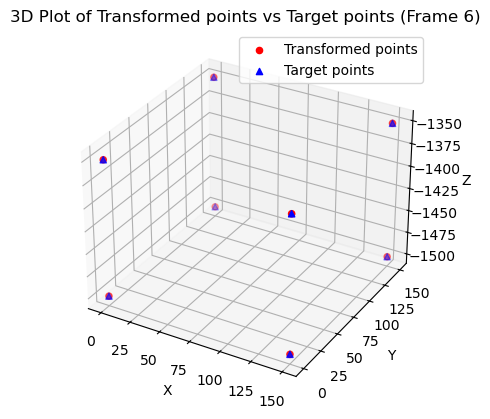

Frame 7 RMSE: 0.0


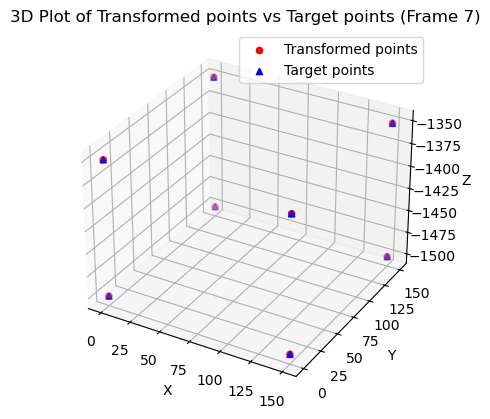

Frame 8 RMSE: 0.0


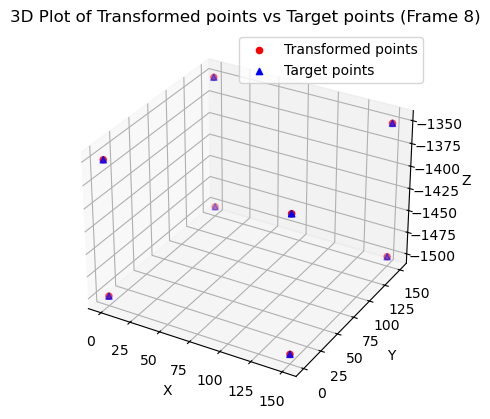

In [10]:
F_D_point_cloud = perform_registration_for_frames(calreadings_frames, calbody_vectors, vector_type='D')
calbody_vectors = d_vectors
rmse_results = {}

# Loop through each frame in the point cloud registration results
for frame_num, frame in F_D_point_cloud.items():
    # Extract the source points (calbody a_vectors) for transformation
    d_points = [Vector(vec.coords[0], vec.coords[1], vec.coords[2]) for vec in calbody_vectors]  # Source points (a_vectors)
    
    # Extract the target points (D_points) from calreadings_frames
    D_points = [Vector(vec.coords[0], vec.coords[1], vec.coords[2]) for vec in calreadings_frames[frame_num]['d_vectors']]  # Target points

    # Apply the transformation to d_points
    transformed_d_points = transform_points(frame, d_points)

    # Compute the RMSE between the transformed d_points and D_points
    transformed_array = np.array([v.as_array() for v in transformed_d_points])
    target_array = np.array([v.as_array() for v in D_points])
    rmse = compute_rmse(transformed_array, target_array)
    rmse_results[frame_num] = rmse

    # Output the RMSE result
    print(f"Frame {frame_num} RMSE: {rmse}")

    # Plot the transformed d_points vs target D_points
    plot_3d_transformed_vs_target(frame_num, transformed_d_points, D_points)


In [11]:
import numpy as np

def compute_C_expected_for_all_frames(F_D_dict, F_A_dict, c_vectors):
    """
    Compute C(expected) for each frame using the Frame class and the formula C(expected) = F_D^−1 • F_A • c_i.
    
    Args:
    F_D_list (list of Frame): List of Frame objects F_D for each frame.
    F_A_list (list of Frame): List of Frame objects F_A for each frame.
    c_vectors (np.ndarray): Nx3 or Nx4 array of c_i vectors (Nx3 for 3D or Nx4 for homogeneous 3D).

    Returns:
    dict: A dictionary where keys are frame numbers and values are Nx3 or Nx4 arrays of C_expected vectors.
    """
    assert F_D_dict.keys() == F_A_dict.keys(), "F_D_dict and F_A_dict must have the same frame numbers"

    C_expected_results = {}

    # Loop over each common frame number in both dictionaries
    for frame_num in F_D_dict.keys():
        F_D = F_D_dict[frame_num]
        F_A = F_A_dict[frame_num]

        # Debugging: Check what F_D and F_A actually are
        #print(f"Frame {frame_num}:")
        #print(f"F_D: {F_D}")
        #print(f"F_A: {F_A}")

        # Check if F_D and F_A are Frame objects
        if not isinstance(F_D, Frame) or not isinstance(F_A, Frame):
            raise TypeError(f"Expected F_D and F_A to be Frame objects, but got {type(F_D)} and {type(F_A)}")

        # Step 1: Compute the inverse of F_D for this frame
        F_D_inv = F_D.inv()

        # Step 2: Initialize an empty list to store the C_expected results for this frame
        C_expected_list = []

        # Step 3: Loop over each vector c_i in c_vectors
        for c_i in c_vectors:
            # Step 4: Compute F_A • c_i (this applies F_A's transformation to c_i)
            F_A_c_i = F_A @ c_i

            # Step 5: Compute F_D^−1 • (F_A • c_i) (this applies the inverse transformation of F_D)
            C_expected = F_D_inv @ F_A_c_i

            # Append the result to the list for this frame
            C_expected_list.append(C_expected)

        # Store the results for this frame in the dictionary
        C_expected_results[frame_num] = np.array(C_expected_list)

    return C_expected_results

C_expected_results = compute_C_expected_for_all_frames(F_D_point_cloud, F_A_point_cloud, c_vectors)

Frame 1 RMSE: 0.0


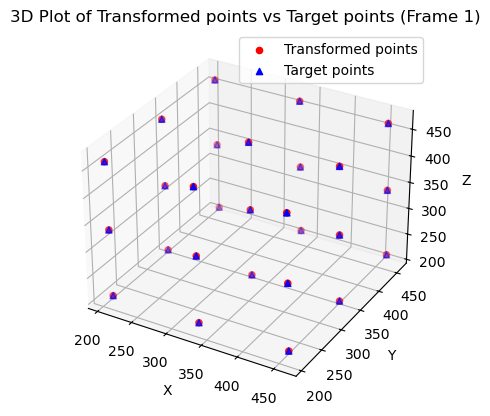

Frame 2 RMSE: 20.640581130981445


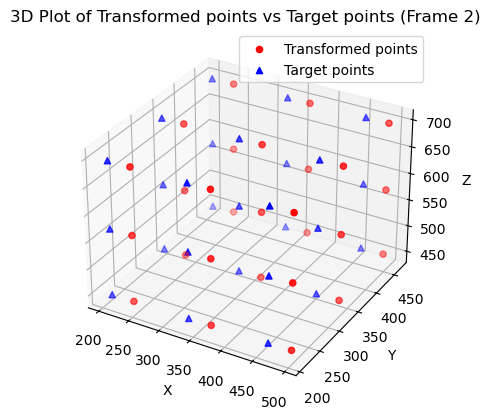

Frame 3 RMSE: 17.544408798217773


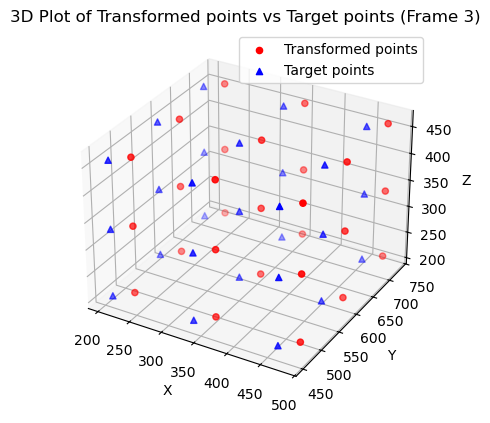

Frame 4 RMSE: 28.442302703857422


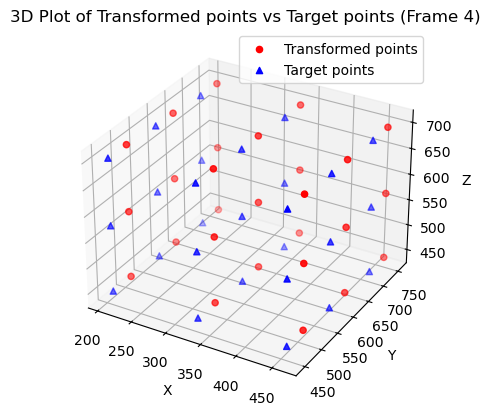

Frame 5 RMSE: 10.62895393371582


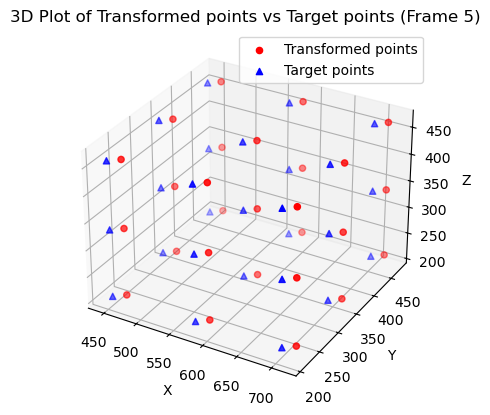

Frame 6 RMSE: 13.862958908081055


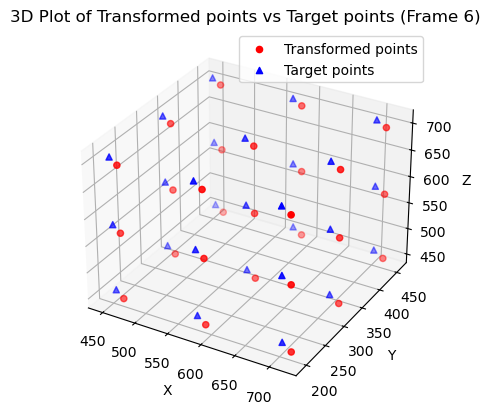

Frame 7 RMSE: 29.9886474609375


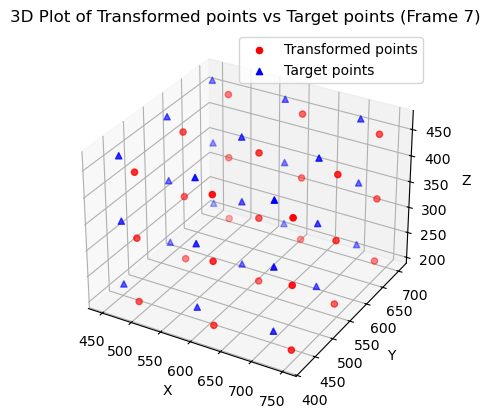

Frame 8 RMSE: 3.8895411491394043


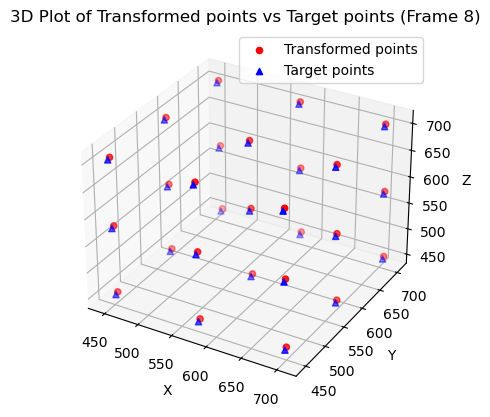

In [12]:
rmse_results = {}

# Loop through each frame in C_expected_results
for frame_num, C_expected_vectors in C_expected_results.items():
    # Extract C_expected points (already transformed) and real C_i points for the current frame
    C_i_vectors = [Vector(vec.coords[0], vec.coords[1], vec.coords[2]) for vec in frames_data[frame_num]['c_vectors']]  # Real C_i points

    # Convert to NumPy arrays for RMSE calculation
    C_expected_array = np.array([v.as_array() for v in C_expected_vectors])
    C_i_array = np.array([v.as_array() for v in C_i_vectors])

    # Compute the RMSE between C_expected and C_i
    rmse = compute_rmse(C_expected_array, C_i_array)
    rmse_results[frame_num] = rmse

    # Output the RMSE result
    print(f"Frame {frame_num} RMSE: {rmse}")

    # Plot the transformed C_expected vs target C_i
    plot_3d_transformed_vs_target(frame_num, C_expected_vectors, C_i_vectors)

In [13]:
def compute_midpoint(observations):
    """
    Compute the midpoint G0 from the observed points G.
    observations: List of 3D points (Nx3 array).
    Returns the midpoint G0.
    """
    return np.mean(observations, axis=0)

def translate_points(observations, midpoint):
    """
    Translate the observations relative to the midpoint G0.
    observations: List of 3D points (Nx3 array).
    midpoint: The calculated midpoint G0 (1x3 array).
    Returns the translated points g_j = G_j - G0.
    """
    return observations - midpoint

def fit_sphere(points):
    """
    Fits a sphere to a set of 3D points using nonlinear least squares optimization.

    Parameters:
    points (array-like): An Nx3 array or list of (x, y, z) coordinates.

    Returns:
    center (numpy.ndarray): The (x, y, z) coordinates of the sphere's center.
    radius (float): The radius of the sphere.
    residuals (float): The sum of squared residuals of the fit.
    """

    # Convert input to a NumPy array
    points = np.asarray(points)
    x = points[:, 0]
    y = points[:, 1]
    z = points[:, 2]

    # Initial guess for the sphere's center (mean of the points)
    x0 = np.mean(x)
    y0 = np.mean(y)
    z0 = np.mean(z)
    r0 = np.mean(np.sqrt((x - x0)**2 + (y - y0)**2 + (z - z0)**2))

    initial_guess = np.array([x0, y0, z0, r0])

    # Define the residuals function
    def residuals(params, x, y, z):
        xc, yc, zc, r = params
        return np.sqrt((x - xc)**2 + (y - yc)**2 + (z - zc)**2) - r

    # Perform the least squares optimization
    result = least_squares(residuals, initial_guess, args=(x, y, z))

    # Extract the optimized parameters
    xc, yc, zc, r = result.x
    residual_sum = 2 * result.cost  # total sum of squared residuals

    center = np.array([xc, yc, zc])
    radius = r

    return center, radius, residual_sum

def read_empivot_file(file_path: str):
    """
    Reads an EMPIVOT.TXT file and extracts the G_i points for each frame.

    Args:
    file_path (str): Path to the EMPIVOT.TXT file.

    Returns:
    tuple: A list of frames, where each frame contains a list of G_i vectors (Nx3 array),
           the number of EM markers (N_G), and the number of frames (N_frames).
    """
    frames = {}  # List to store G_i points for each frame

    with open(file_path, 'r') as file:
        lines = file.readlines()

        # First line contains N_G, N_frames, and file name
        header = lines[0].split(',')
        N_G = int(header[0].strip())  # Number of EM markers on the probe
        N_frames = int(header[1].strip())  # Number of frames
        file_name = header[2].strip()  # File name (not used in processing)

        # Start reading G_i points for each frame
        current_line = 1
        for frame_idx in range(N_frames):
            frame_points = []
            # Read G_i points for this frame
            for i in range(N_G):
                G_coords = list(map(float, lines[current_line].split(',')))
                frame_points.append(Vector(*G_coords))
                current_line += 1
            frames[frame_idx + 1] = frame_points

    return frames, N_G, N_frames

def process_frame_midpoints(frames):
    """
    For each frame, computes the midpoint of the observed points and translates
    the observations relative to this midpoint.

    Args:
    frames (list): A list of frames where each frame is a list of Vector objects representing 3D points.

    Returns:
    list: A list of frames where each frame contains the translated points g_j relative to the midpoint G_0.
    """
    translated_frames = {}

    for (frame_num, frame) in frames.items():
        # Convert the frame (list of Vector objects) to a NumPy array for midpoint computation
        #print(frame)
        observations = np.array([v.coords for v in frame])

        # Step 1: Compute the midpoint G_0 for the frame
        G0 = compute_midpoint(observations)

        # Step 2: Translate the points relative to the midpoint
        translated_observations = translate_points(observations, G0)

        # Convert the translated points back to Vector objects
        translated_vectors = [Vector(g[0], g[1], g[2]) for g in translated_observations]
        
        translated_frames[frame_num] = translated_vectors

    return translated_frames


In [14]:
G_points_frames, _, _ = read_empivot_file("PA_1_Data/pa1-debug-a-empivot.txt")
small_g_j = process_frame_midpoints(G_points_frames)

In [15]:
def perform_registration_for_frames(G_points_frames, small_g_j):
    """
    Perform point cloud registration for each frame
    
    
    Returns:
    dict: Dictionary with frame numbers as keys and (R, t) as values where R is the rotation matrix and t is the translation vector.
    """
    registration_results = {}

   
# Perform registration for each frame
    for frame_num, frame_data in G_points_frames.items():
       
        source_points = np.array([vec.coords for vec in small_g_j[frame_num]])
        target_points = np.array([vec.coords for vec in frame_data])

        # Perform point cloud registration using least squares to find R and t
        R_optimal, t_optimal = point_cloud_registration_least_squares(target_points, source_points)

        # Store the result for this frame
        registration_results[frame_num] = Frame(R_optimal, t_optimal)

    return registration_results

In [16]:
F_g_frames = perform_registration_for_frames(G_points_frames, small_g_j)

In [17]:
points = []

# Loop through each frame and compute midpoints
for frame_num, G_j in F_g_frames.items():
    # Compute the midpoint of the points in the frame
    midpoint = compute_midpoint(G_j)  # G_j is the list of vectors for the current frame
    points.append(midpoint)  # Store the midpoint for later sphere fitting

# Fit a sphere to the computed midpoints
tip_EM_pointer, _, _ = fit_sphere(np.array(points))
tip_EM_pointer = Vector(tip_EM_pointer[0], tip_EM_pointer[1], tip_EM_pointer[2])


In [18]:
P_dimple = {}
for frame_num, frame in F_g_frames.items():
    P_dimple[frame_num] = frame @ tip_EM_pointer
    

In [19]:
P_dimple

{1: <__main__.Vector at 0x2167f3839e0>,
 2: <__main__.Vector at 0x2167f093230>,
 3: <__main__.Vector at 0x2167f381dc0>,
 4: <__main__.Vector at 0x2167f381be0>,
 5: <__main__.Vector at 0x2167f383500>,
 6: <__main__.Vector at 0x2167f381760>,
 7: <__main__.Vector at 0x2167f381430>,
 8: <__main__.Vector at 0x2167f3818e0>,
 9: <__main__.Vector at 0x2167f3817c0>,
 10: <__main__.Vector at 0x2167f381d90>,
 11: <__main__.Vector at 0x2167f382090>,
 12: <__main__.Vector at 0x2167f382c60>}

In [20]:
tip_EM_pointer

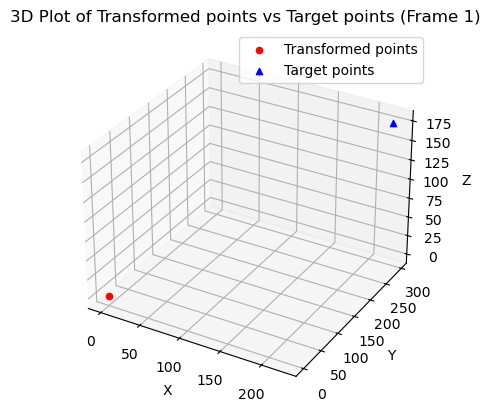

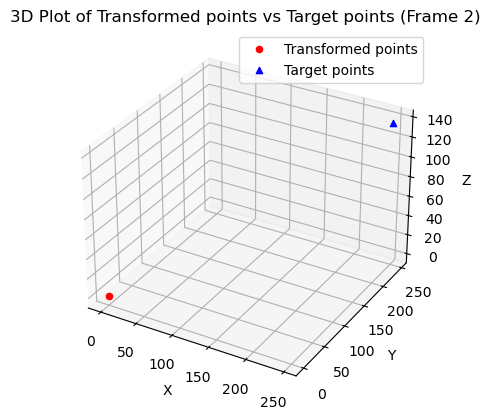

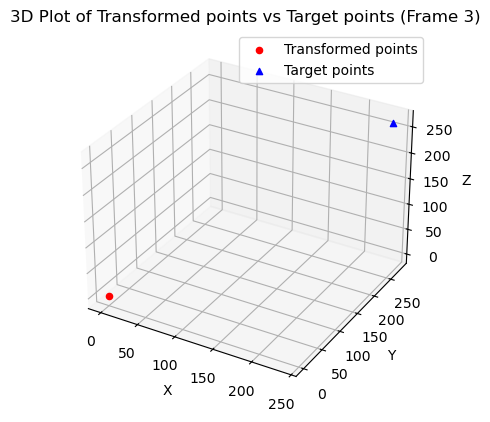

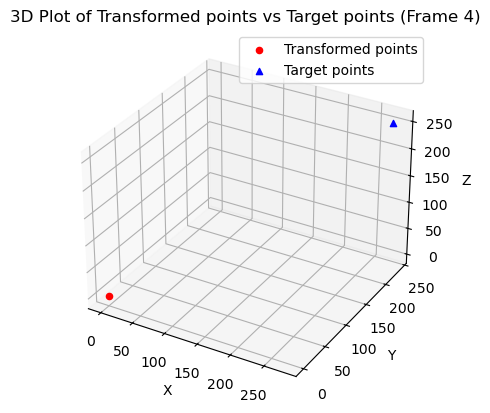

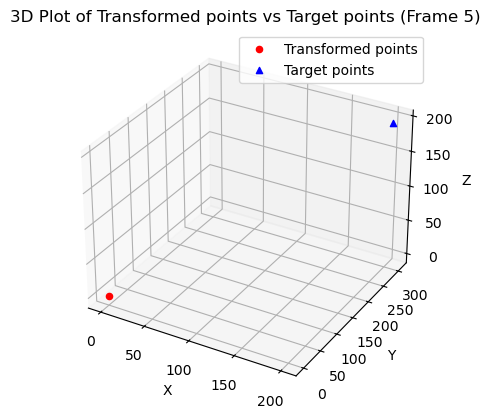

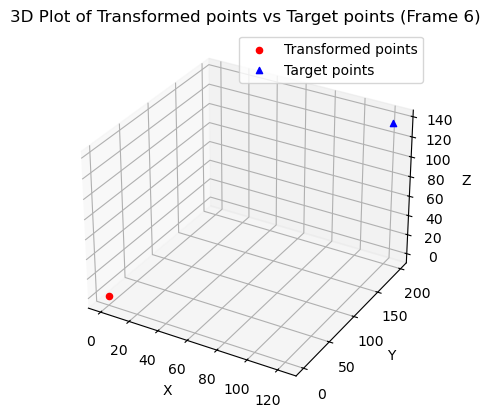

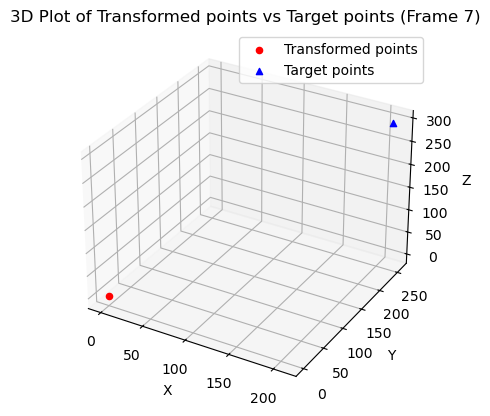

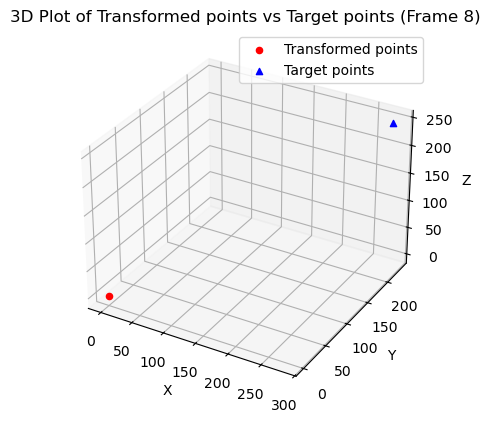

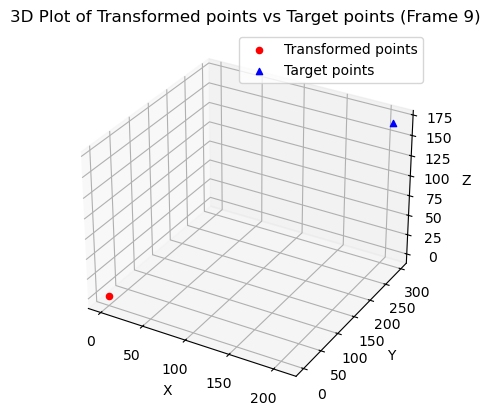

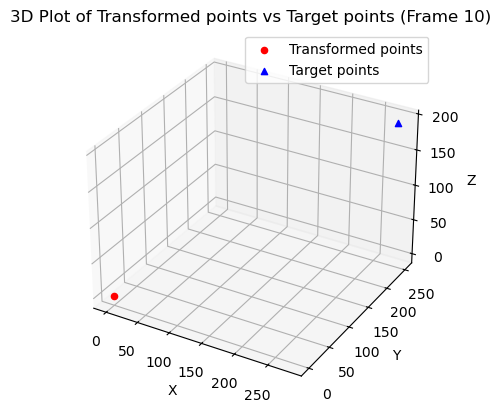

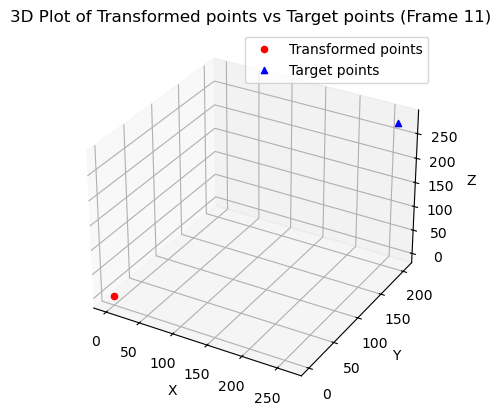

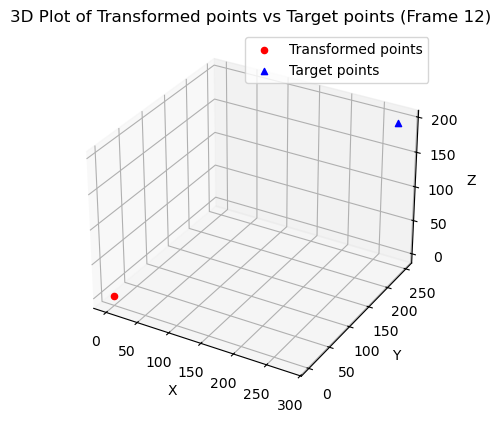

In [21]:
# Ensure tip_EM_pointer is passed as a list of Vector objects
#tip_EM_pointer_vecs = [Vector(tip_EM_pointer[0], tip_EM_pointer[1], tip_EM_pointer[2])]


tip_EM_pointer_vecs = [tip_EM_pointer]

# Plot transformed vectors vs target vectors for the first frame
for i in range(1, len(P_dimple) + 1):
    plot_3d_transformed_vs_target(frame_num= i, transformed_vectors=tip_EM_pointer_vecs, target_vectors=[P_dimple[i]])


In [22]:
#use F_D_frames to do 
# P_dimple of optical = (F_H . t_h)